In [1]:
# load functions for data analysis
from scr_analysis_functions_fyp import experimental, visualizeStats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf    
import pandas, os, scipy
import seaborn as sns
import numpy as np

% pylab inline
pandas.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_path = '/Users/biota/Desktop/sSL/experiment_2/analysis/data_physio_study1'
day_one = experimental(data_path)
day_one.day = 1
day_one.preprocessData()

In [3]:
day_two = experimental(data_path)
day_two.day = 2
day_two.preprocessData()

In [4]:
cb = []
bc = []
for iSubject in range(0,len(day_two.subjectNames)): 
    if str.find(day_two.subjectNames[iSubject],'_cb_') != -1: 
        cb.append(iSubject)
    else: 
        bc.append(iSubject)

cb = np.array(cb)
bc = np.array(bc)

In [5]:

order = np.zeros(day_two.nSubjects)
order[cb] = 1


In [6]:
conditioning_pos_offsets = np.zeros([day_one.nSubjects,len(range(3,12))])
conditioning_neg_offsets = np.zeros([day_one.nSubjects,len(range(3,12))])

day_one.nSeconds = 4.5
conditioning = list(range(3,12))
for iStim in range(0,len(conditioning)):
    conditioning_pos_offsets[:,iStim], conditioning_neg_offsets[:,iStim] = day_one.amplitudeDifference('trans',
                                                                                                       conditioning[iStim],
                                                                                                       'offset');
conditioning_significance_offsets = np.zeros(day_one.nSubjects)
for iSubject in range(0,day_one.nSubjects): 
    conditioning_significance_offsets[iSubject] = scipy.stats.wilcoxon(conditioning_pos_offsets[iSubject,:],
                                                                     conditioning_neg_offsets[iSubject,:])[1];

In [7]:
start_con_onsets = 4
end_con_onsets   = 13
conditioning_pos_onsets = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])
conditioning_neg_onsets = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])

day_one.nSeconds = 4.5
conditioning = list(range(start_con_onsets,end_con_onsets))

for i_stim in range(0,len(conditioning)):
    conditioning_pos_onsets[:,i_stim], conditioning_neg_onsets[:,i_stim] = day_one.amplitudeDifference('trans',
                                                                           conditioning[i_stim],
                                                                           'onset');
conditioning_significance_onsets = np.zeros(day_one.nSubjects)

for i_subject in range(0,day_one.nSubjects): 
    conditioning_significance_onsets[i_subject] = scipy.stats.wilcoxon(conditioning_pos_onsets[i_subject,:],
                                                                 conditioning_neg_onsets[i_subject,:])[1];

In [32]:

iStim = 0
day_two.nSeconds = 4.5
renewal_plus, renewal_minus = day_two.amplitudeDifference('trans',iStim,'onset');


In [33]:
log_conditioning_pos_onsets = log(1 + conditioning_pos_onsets)
log_conditioning_neg_onsets = log(1 + conditioning_neg_onsets)
log_renewal_plus = log(1 + renewal_plus)
log_renewal_minus = log(1 + renewal_minus)

log_learning = mean(log_conditioning_pos_onsets - log_conditioning_neg_onsets,1)
log_renewal =  log_renewal_plus - log_renewal_minus 

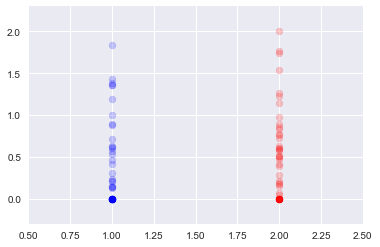

In [34]:
tmp_alpha = .2
sns.set_style("dark", {'axes.grid' : True})
scatter(np.ones(sum(order==True)), log_renewal_minus[order==True], color='blue',alpha=tmp_alpha)
scatter(np.ones(sum(order==True))+1, log_renewal_plus[order==True], color='red',alpha=tmp_alpha)

tmp_len = len(np.nonzero(order==False)[0])
scatter(np.ones(tmp_len), log_renewal_minus[order==False], color='blue',alpha=tmp_alpha)
scatter(np.ones(tmp_len)+1, log_renewal_plus[order==False], color='red',alpha=tmp_alpha)

xlim(.5,2.5) ; ylim(-.3,2.3); 

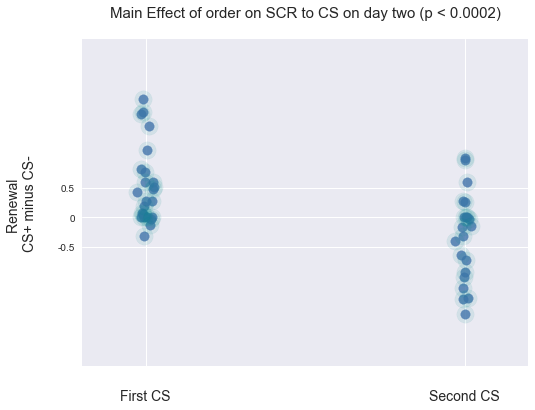

In [14]:

figure(figsize=[8,6])
sns.set_style("dark", {'axes.grid' : True})
jitter = np.random.randn(len(order))/100
scatter(order + jitter,log_renewal, alpha=.8, s=90)
scatter(order + jitter,log_renewal, color='darkcyan', alpha=.1, s=300)
ylabel('Renewal \nCS+ minus CS-\n', rotation=90, fontsize=14)

yticks([-.5,0,.5,],[-.5,0,.5])
xticks([0, 1],['\nFirst CS','\nSecond CS'], fontsize=14)
xlim(-.2, 1.2)
ylim(-2.5, 3)
title('Main Effect of order on SCR to CS on day two (p < %.04f)\n'%p_val_order_effects, fontsize=15); 


In [12]:

SCR_all = pandas.DataFrame({'renewal':log_renewal, 'prediction':log_learning, 'order':order}) 


In [13]:
order_effects = pandas.DataFrame({'renewal':log_renewal, 'order':order}) 
formula = 'renewal ~ order'
model = ols(formula, SCR_all).fit()
aov_table = anova_lm(model, typ=2)
print '\n\t\t', formula, '\n\n', aov_table, '\n\n'
p_val_order_effects = aov_table.values[0,3]


		renewal ~ order 

             sum_sq    df          F    PR(>F)
order      8.160960   1.0  16.541136  0.000199
Residual  21.215065  43.0        NaN       NaN 




In [16]:
# figure(figsize=(10,6))

# scatter(log_learning, log_renewal,color='xkcd:indigo',alpha=.3,s=180, label='CS+ first')
# scatter(log_learning[order==True], log_renewal[order==True],marker='x', color='xkcd:indigo',alpha=.4, s=10, linewidth=15, label='CS- first')

# # control aesthetics
# lgnd = legend(fontsize=13, fancybox=True, frameon=True, bbox_to_anchor=(.20, 1, 1, 0))
# lgnd.get_frame().set_edgecolor('xkcd:indigo')
# lgnd.get_frame().set_linewidth(2)
# lgnd.get_frame().set_alpha(.4)

# xlabel('Conditioning on day one\n CS+ minus CS-',fontsize=13)
# ylabel('Renewal\n CS+ minus CS-',fontsize=13)
# yticks([-.1,0,.1],[-.1,0,.1])
# xticks([-.1,0,.1],[-.1,0,.1])
# title('Relationship between conditioning to CS+ on day 1 with renewal\n',fontsize=15); 


In [17]:


##### SHOW ABOVE PLOT PAIRED WITH OFFSET PLOT (OPERATIONALIZATION OF EMOTIONAL CONTAGION)
##### SHOW ABOVE PLOT AS OPERATIONALIZATION OF 





In [ ]:


# INTRO (8-10 minutes)
# 1 ) real world example 
# 1a) the good news ... evolutionary story ... emotional contagion / RL model  
# 2 ) sea change in the literature 
# 3 ) 
# 



In [ ]:
# correlation scores for 
# full sample + subsamples (CS+ first, CS- first)
#
# half median split: 
#     first half = people who conditioned most
#   second half = people who conditioned least 
# 
# the lean model of vicarious conditoining = 
#
#      "emotional contagion" / "associative model" 
#       -------- connect these dots here ----------
#      TD learning is to emotional contagion as social structure learning is to causal inference 
#      not just vicarious emotion but understanding of cause and effect
#
#       (masserman, lanzetta and zaughn) 

In [ ]:


# RENEWAL--WHY? 
# front end either
# 1) REAL WORLD RELEVANCE
# 2) THEORY OF LEARNING

# or switch

# middle: as an explanation 
# end 



In [48]:


# SCR_all = pandas.DataFrame({'renewal':log_renewal, 'prediction':log_learning, 'order':order}) 



In [18]:
# formula = 'renewal ~ prediction'
# model = ols(formula, SCR_all).fit()
# aov_table = anova_lm(model, typ=2)
# print '\n\n\t\t', formula, '\n\n', aov_table

# formula = 'renewal ~ prediction + C(order)'
# model = ols(formula, SCR_all).fit()
# aov_table = anova_lm(model, typ=2)
# p_value = aov_table.values[2,3]
# print '\n\n\t', formula, '\n\n', aov_table, '\n\n'

In [50]:
# control for non-responders using raw data

In [19]:
start_con_onsets, end_con_onsets = 4, 13

conditioning_pos_onsets_raw = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])
conditioning_neg_onsets_raw = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])

day_one.nSeconds = 4.5
conditioning_inds = list(range(start_con_onsets, end_con_onsets))

for i_stim in range(0,len(conditioning_inds)):
    conditioning_pos_onsets_raw[:,i_stim], conditioning_neg_onsets_raw[:,i_stim] = day_one.amplitudeDifference('raw',
                                                                                   conditioning_inds[i_stim],
                                                                                   'onset');

In [20]:
day_two.nSeconds = 4.5
raw_renewal_plus, raw_renewal_minus = day_two.amplitudeDifference('raw',0,'onset');

In [21]:

responders = np.array(mean(conditioning_pos_onsets_raw,1) > .02)

In [22]:
SCR = pandas.DataFrame({'renewal':log_renewal[responders], 
                        'prediction':log_learning[responders], 
                        'order':order[responders]})

In [23]:

formula = 'renewal ~ prediction'
model_prediction_responders = ols(formula, SCR).fit()
aov_table_responders = anova_lm(model_prediction_responders, typ=2)
print '\n\n\t\t', formula, '\n\n', aov_table_responders

formula = 'renewal ~ prediction + C(order)'
model_prediction_order_responders = ols(formula, SCR).fit()
aov_table_order_responders = anova_lm(model_prediction_order_responders, typ=2)
p_value = aov_table_order_responders.values[2,3]
print '\n\n\t', formula, '\n\n', aov_table_order_responders, '\n\n'




		renewal ~ prediction 

               sum_sq    df          F    PR(>F)
prediction   7.144081   1.0  12.492717  0.001306
Residual    17.727650  31.0        NaN       NaN


	renewal ~ prediction + C(order) 

               sum_sq    df          F    PR(>F)
C(order)     6.379284   1.0  16.863970  0.000285
prediction   3.415634   1.0   9.029407  0.005324
Residual    11.348366  30.0        NaN       NaN 




In [24]:
p_value_responders_order_prediction = aov_table_order_responders.values[1,3]
p_value_responders_prediction = aov_table_responders.values[0,3]

In [25]:
p_value_responders_prediction

0.0013062690318899745

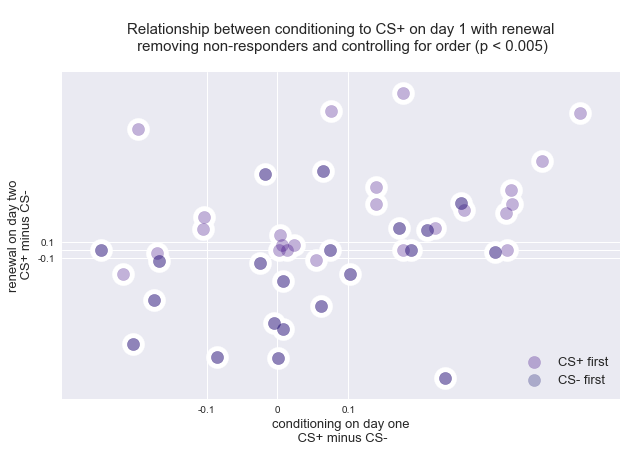

In [26]:
figure(figsize=(10,6))

iStim = 0
day_two.nSeconds = 4.5
renewal_plus, renewal_minus = day_two.amplitudeDifference('trans',iStim,'onset');

log_conditioning_pos_onsets = log(1 + conditioning_pos_onsets)
log_conditioning_neg_onsets = log(1 + conditioning_neg_onsets)
log_renewal_plus = log(1 + renewal_plus)
log_renewal_minus = log(1 + renewal_minus)

log_learning_responders = mean(log_conditioning_pos_onsets - log_conditioning_neg_onsets,1)[responders]
log_renewal_responders =  (log_renewal_plus - log_renewal_minus)[responders]
cb = np.nonzero(order[responders])[0]

scatter(log_learning, log_renewal,color='xkcd:white',alpha=1,s=500)
scatter(log_learning, log_renewal,color='xkcd:indigo',alpha=.3,s=150, label='CS+ first')
scatter(log_learning[order == True], log_renewal[order == True], color='midnightblue',alpha=.3, s=150,  label='CS- first')
sns.set_style("dark", {'axes.grid' : True})
legend(loc=4, fontsize=13)
xlabel('conditioning on day one\n CS+ minus CS-',fontsize=13)
ylabel('renewal on day two\n CS+ minus CS-',fontsize=13)
yticks([-.1,0,.1],[-.1,'',.1])
xticks([-.1,0,.1],[-.1,0,.1])

title('\nRelationship between conditioning to CS+ on day 1 with renewal\n removing non-responders and controlling for order (p < %.03f)\n' 
      %(p_value_responders_order_prediction), fontsize=15); 



	renewal ~ contagion_learning + C(order) 

                       sum_sq    df          F    PR(>F)
C(order)            10.153673   1.0  20.708703  0.000083
contagion_learning   0.054716   1.0   0.111595  0.740659
Residual            14.709284  30.0        NaN       NaN 




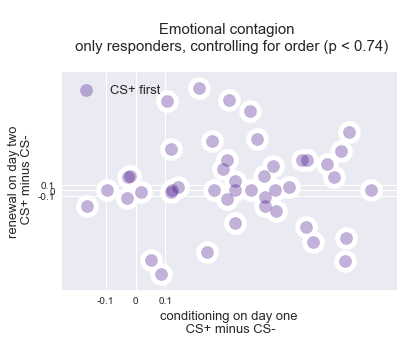

In [27]:
conditioning_pos_offsets

log_conditioning_pos_offsets = log(1 + conditioning_pos_offsets)
log_conditioning_neg_offsets = log(1 + conditioning_neg_offsets)

contagion_learning = mean(log_conditioning_pos_offsets - log_conditioning_neg_offsets,1)#
cb = np.nonzero(order[responders])[0]

SCR['contagion_learning'] = contagion_learning[responders]
formula = 'renewal ~ contagion_learning + C(order)'
contagion_model = ols(formula, SCR).fit()
aov_table_contagion = anova_lm(contagion_model, typ=2)
p_value_contagion = aov_table_contagion.values[1,3]
print '\n\n\t', formula, '\n\n', aov_table_contagion, '\n\n'

scatter(contagion_learning, log_renewal,color='xkcd:white',alpha=1,s=500)
scatter(contagion_learning, log_renewal,color='xkcd:indigo',alpha=.3,s=150, label='CS+ first')
#scatter(contagion_learning[order == True], contagion_renewal[order == True], color='midnightblue',alpha=.3, s=150,  label='CS- first')
sns.set_style("dark", {'axes.grid' : True})
legend(loc=2, fontsize=13)
xlabel('conditioning on day one\n CS+ minus CS-',fontsize=13)
ylabel('renewal on day two\n CS+ minus CS-',fontsize=13)
yticks([-.1,0,.1],[-.1,0,.1])
xticks([-.1,0,.1],[-.1,0,.1])
title('\nEmotional contagion \n only responders, controlling for order (p < %.02f)\n' 
      %(p_value_contagion), fontsize=15); 

NameError: name 'contagion_renewal' is not defined

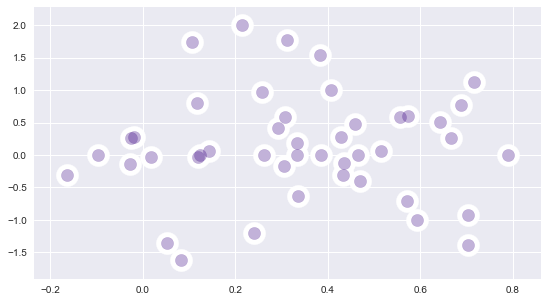

In [28]:
figure(figsize=[20,5])
sns.set_style("dark", {'axes.grid' : True})
subplot(121)
scatter(contagion_learning, log_renewal,color='xkcd:white',alpha=1,s=500)
scatter(contagion_learning, log_renewal,color='xkcd:indigo',alpha=.3,s=150, label='CS+ first')
scatter(contagion_learning[order == True], contagion_renewal[order == True], color='midnightblue',alpha=.3, s=150,  label='CS- first')

yticks([-.1,0,.1],[-.1,'',.1])
xticks([-.1,0,.1],[-.1,0,.1])

legend(loc=2, fontsize=13)
xlabel('Mean response to US on day one\n CS+ minus CS-',fontsize=13)
ylabel('Renewal on day two\n CS+ minus CS-',fontsize=13)
xlim(-.4,1)
title('\nRelating the magnitude and direction of response to shock on day one \n with renewal on day two--controlling for order (p < %.02f)\n' 
      %(p_value_contagion), fontsize=15); 

subplot(122)
scatter(log_learning, log_renewal,color='xkcd:white',alpha=1,s=500)
scatter(log_learning, log_renewal,color='xkcd:indigo',alpha=.3,s=150, label='CS+ first')
scatter(log_learning[order == True], log_renewal[order == True], color='midnightblue',alpha=.3, s=150,  label='CS- first')

yticks([-.1,0,.1],[-.1,'',.1])
xticks([-.1,0,.1],[-.1,0,.1])

legend(loc=4, fontsize=13)
xlabel('Conditioning on day one\n CS+ minus CS-',fontsize=13)
ylabel('Renewal on day two\n CS+ minus CS-',fontsize=13)
xlim(-.4,1)
title('\nRelating the magnitude and direction of conditioning to CS+ on day one \nwith renewal on day two--controlling for order (p < %.03f)\n' 
      %(p_value_responders_order_prediction), fontsize=15); 

In [136]:
conditioning_significance_raw_onsets = np.zeros(day_one.nSubjects)

for i_subject in range(0,day_one.nSubjects): 
    conditioning_significance_raw_onsets[i_subject] = scipy.stats.ttest_ind(conditioning_pos_onsets_raw[i_subject,:],
                                                                 conditioning_neg_onsets_raw[i_subject,:])[1];

In [137]:
conditioned_subjects_= find(conditioning_significance_onsets < .05)

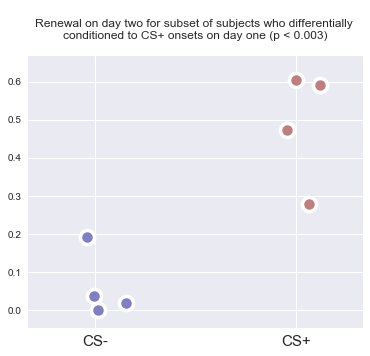

In [246]:
figure(figsize=[6,5])
sns.set_style("dark", {'axes.grid' : True})
#scatter(order[cb], log_renewal_plus[cb])
tmp_len_p = len(log_renewal_plus[conditioned_subjects_])
tmp_len_n = len(log_renewal_minus[conditioned_subjects_])
jitter_p = np.random.randn(tmp_len_p)/80
jitter_n = np.random.randn(tmp_len_n)/80

_results_ = scipy.stats.ttest_ind(log_renewal_plus[conditioned_subjects_], log_renewal_minus[conditioned_subjects_])


scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_],s=300, alpha=1,color='white') 
scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_],s=100, alpha=.5,color='maroon') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_]+ jitter_p,s=300, alpha=1, color='white') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_]+ jitter_p,s=100, alpha=.5, color='darkblue') 
xlim([-.1,.4])
#ylim(-.2,.8)
xticks([0,.3], ['CS-', 'CS+'], fontsize=15); 
#yticks([0,.5], [], fontsize=15); 
title('\nRenewal on day two for subset of subjects who differentially \nconditioned to CS+ onsets on day one (p < %.03f)\n'%_results_.pvalue); 

In [241]:
print(cb, conditioned_subjects_)

(array([ 5,  7, 10, 11, 14, 15, 18, 20, 25, 26, 27, 28, 29, 30]), array([ 3, 11, 12, 16]))


In [169]:
import behavioral_analysis_functions_fyp as ba_fun
self_report, subject_names = ba_fun.generate_data_frame()
# ba_fun.correlation_matrix(self_report)

In [170]:

SCR_all = pandas.DataFrame({'renewal':log_renewal, 'prediction':log_learning, 'order':order}) 
SCR_all['subject_names'] = [day_two.subjectNames[ii][0:4] for ii in range(day_two.nSubjects)]

In [171]:
for ii in range(len(SCR_all)): 
    name = SCR_all.subject_names.values[ii]
    found = 0
    for jj in range(len(self_report)): 
        if name in self_report.index.values[jj]: 
            found = 1
    if found == 0 : 
        missing_subject = ii

In [172]:
SCR_all = SCR_all.drop(missing_subject)

In [173]:
tmp_data = {}
indices = [] 
for ii in range(len(SCR_all.keys())): 
    tmp_data[SCR_all.keys()[ii]] = SCR_all[SCR_all.keys()[ii]].values

for ii in range(len(self_report.keys())): 
    tmp_data[self_report.keys()[ii]] = self_report[self_report.keys()[ii]].values

In [174]:
physio_selfreport = pandas.DataFrame.from_dict(tmp_data)

In [175]:
cols = physio_selfreport.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
physio_selfreport.columns = cols

cols = physio_selfreport.columns
cols = cols.map(lambda x: x.replace(':', '') if isinstance(x, (str, unicode)) else x)
physio_selfreport.columns = cols

In [176]:
#shorter_conditioning = np.delete(conditioning_significance_onsets, missing_subject) 
#physio_selfreport['conditioned_subjects'] = shorter_conditioning 

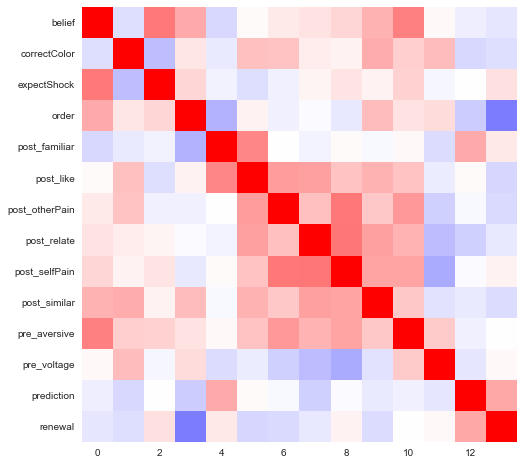

In [177]:
figure(figsize=[8,8])
sns.set_style("dark", {'axes.grid' : False})
whole_corr = physio_selfreport.corr()
imshow(whole_corr, cmap='bwr', vmax=1, vmin=-1)
yticks(range(0,len(whole_corr.keys())),whole_corr.keys()); 

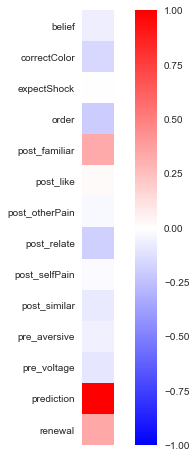

In [178]:
figure(figsize=[8,8])
sns.set_style("dark", {'axes.grid' : False})
imshow(whole_corr[-2:-1].T, cmap='bwr', vmax=1, vmin=-1)
yticks(range(len(whole_corr.keys())),whole_corr.keys()); 
colorbar() ; xticks([]); 

In [180]:
formula = 'renewal ~ pre_voltage + post_selfPain + pre_aversive'
model = ols(formula, physio_selfreport).fit()
aov_table = anova_lm(model, typ=2)
print '\n\n', formula, '\n\n', aov_table



renewal ~ pre_voltage + post_selfPain + pre_aversive 

                  sum_sq    df         F    PR(>F)
pre_voltage     0.102459   1.0  0.146120  0.704295
post_selfPain   0.155628   1.0  0.221947  0.640120
pre_aversive    0.035841   1.0  0.051115  0.822286
Residual       28.047810  40.0       NaN       NaN


In [183]:
formula = 'renewal ~ expectShock + post_otherPain + post_relate + post_similar + post_like'
model = ols(formula, physio_selfreport).fit()
aov_table = anova_lm(model, typ=2)
print '\n\n\t\t', formula, '\n\n', aov_table



		renewal ~ expectShock + post_otherPain + post_relate + post_similar + post_like 

                   sum_sq    df         F    PR(>F)
expectShock      0.319587   1.0  0.453020  0.504977
post_otherPain   0.153892   1.0  0.218145  0.643124
post_relate      0.002122   1.0  0.003008  0.956548
post_similar     0.210123   1.0  0.297854  0.588421
post_like        0.134548   1.0  0.190724  0.664786
Residual        26.807376  38.0       NaN       NaN


In [235]:
formula = 'prediction ~ post_familiar'
model = ols(formula, physio_selfreport).fit()
aov_table = anova_lm(model, typ=2)
print '\n\n\t\t', formula, '\n\n', aov_table



		prediction ~ post_familiar 

                 sum_sq    df         F    PR(>F)
post_familiar  0.152491   1.0  5.239257  0.027178
Residual       1.222431  42.0       NaN       NaN


In [238]:
formula = 'renewal ~ correctColor'
model = ols(formula, physio_selfreport).fit()
aov_table = anova_lm(model, typ=2)
print '\n\n\t\t', formula, '\n\n', aov_table



		renewal ~ correctColor 

                 sum_sq    df        F    PR(>F)
correctColor   0.449839   1.0  0.68009  0.414215
Residual      27.780500  42.0      NaN       NaN


In [78]:


#
#
#
# review: 
#        tie the intro ideas into the measures: three variables per person 
#        overall renewal renewal? 
#        -- uphill battle ... 
#        even controlling for that we still get it 
#        what is it about their experience on day one ... ? 
#        -- learning? (onset)
#        -- contagion? (offset)
#        -- argues against a lean emotional contagion model 
#        what is it? not behavioral things
#        
#
#
